## Imports

In [13]:
import sys
import torch
import cv2
import supervision as sv

stdout = sys.stdout
from super_gradients.training import models
sys.stdout = stdout

from tqdm import tqdm
from supervision.draw.color import ColorPalette


In [14]:
print("supervision.__version__:", sv.__version__)

supervision.__version__: 0.13.0


## Load_YoloNas_Model

In [15]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


In [16]:
best_model = models.get('yolo_nas_s',
                        num_classes=1,
                        checkpoint_path="runs/yolo_nas_s/ckpt_best.pth")
                        # checkpoint_path="runs/yolo_nas_s/average_model.pth")

## Detection__Image

In [17]:
# best_model.predict("../TruckDataset/images/train/time3_frame5_008.jpg", conf=0.25).show()
# predictions = best_model.predict("../TruckDataset/images/train/time3_frame5_008.jpg", conf=0.25)
# prediction_objects = list(predictions._images_prediction_lst)[0]
# print("Number of Detected Trucks in Frame: ", prediction_objects.prediction.labels.shape[0])
# print(prediction_objects.image.shape)

In [18]:
classes = ['truck']

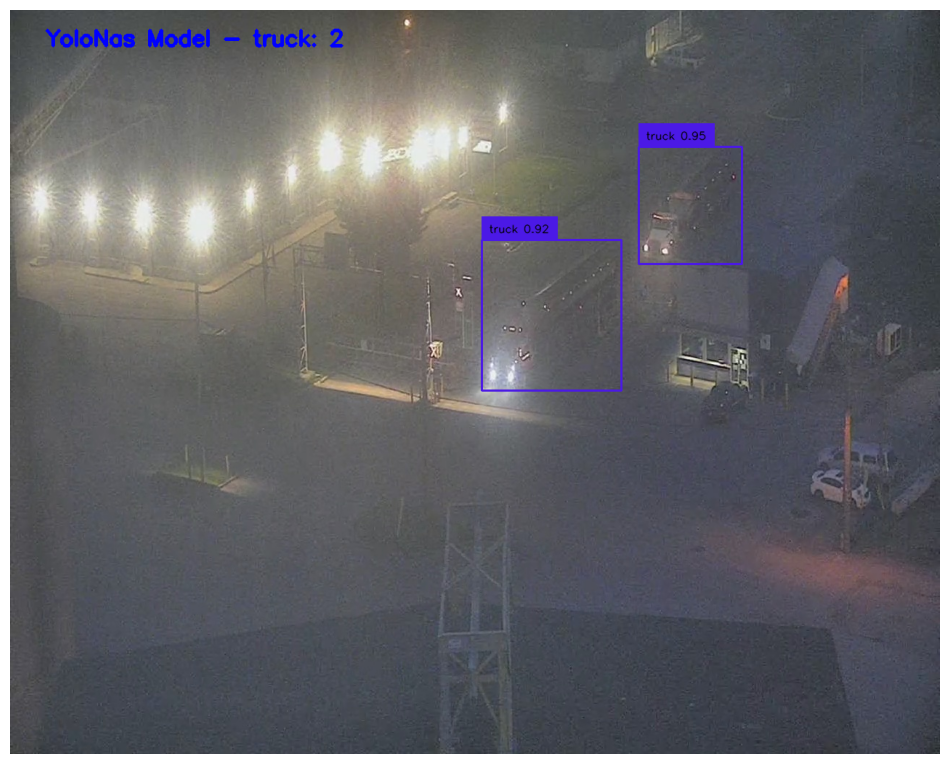

In [19]:
predictions = best_model.predict("../TruckDataset/images/val/time1_frame_142.jpg")
prediction_objects = list(predictions._images_prediction_lst)[0]

detections = sv.Detections(
    xyxy=prediction_objects.prediction.bboxes_xyxy,
    confidence=prediction_objects.prediction.confidence,
    class_id=prediction_objects.prediction.labels.astype(int)
)

labels = [
    f"{classes[class_id]} {confidence:0.2f}"
    for _, _, confidence, class_id, _
    in detections
]

box_annotator = sv.BoxAnnotator()

frame_with_annotations = box_annotator.annotate(
    scene=prediction_objects.image,
    detections=detections,
    labels=labels
)
cv2.putText(frame_with_annotations,f'YoloNas Model - truck: {prediction_objects.prediction.labels.shape[0]}',(50, 50), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 3)

rgb_frame_with_annotations = cv2.cvtColor(frame_with_annotations, cv2.COLOR_BGR2RGB)

sv.plot_image(image=rgb_frame_with_annotations)


## Create Short Video

In [20]:
# Dictionary of different times
# a time have a start and end time 
# each of start and end time is a list: [h, m, s]
## you can comment some of times in dictinary if have short time
times = {'time1' : [[4, 56, 6], [4, 56, 30]],
         'time2' : [[5, 51, 33], [5, 53, 3]],
         'time3' : [[12, 4, 19], [12, 7, 0]],
         'time4' : [[15, 10, 10], [15, 10, 40]],
         'time5' : [[15, 21, 40], [15, 22, 26]],
         'time6' : [[16, 27, 23], [16, 28, 20]],
         'time7' : [[17, 24, 13], [17, 25, 0]],
         'time8' : [[18, 1, 30], [18, 2, 30]],
         'time9' : [[19, 14, 20], [19, 15, 13]]
         }
# times = {'time1' : [[4, 56, 6], [4, 58, 14]],
#          'time2' : [[5, 51, 33], [5, 53, 3]],
#          'time3' : [[6, 46, 22], [6, 43, 18]],
#          'time4' : [[7, 42, 41], [7, 43, 33]],
#          'time5' : [[12, 4, 19], [12, 15, 0]],
#          'time6' : [[15, 10, 10], [15, 10, 40]],
#          'time7' : [[15, 21, 40], [15, 22, 26]],
#          'time8' : [[16, 27, 23], [16, 28, 20]],
#          'time9' : [[17, 24, 13], [17, 25, 0]],
#          'time10' : [[18, 1, 30], [18, 2, 30]],
#          'time11' : [[19, 14, 20], [19, 16, 13]],
#          'time12' : [[20, 45, 20], [20, 47, 38]],
#          'time13' : [[20, 56, 0], [20, 57, 0]],
#          'time14' : [[21, 52, 45], [21, 53, 45]],
#          'time15' : [[23, 24, 30], [23, 25, 10]],
#          'time16' : [[20, 25, 40], [20, 21, 30]]
#          }

In [21]:
cap = cv2.VideoCapture(r"..\..\Data\TruckVideo.mp4")

#output video setting
output_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
output_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

output_fps = cap.get(cv2.CAP_PROP_FPS) 
fourcc = cv2.VideoWriter_fourcc(*'mp4v') # Use 'mp4v' codec for MP4 format

output_path = 'short_video.mp4'

out = cv2.VideoWriter(output_path, fourcc, output_fps, (output_width, output_height))

time_step = 1

for t in times.keys():
    start_time = times[t][0][0] * 3600 + times[t][0][1] * 60  + times[t][0][2]# Convert start time to seconds
    end_time = times[t][1][0] * 3600 + times[t][1][1] * 60  + times[t][1][2] # Convert end time to seconds

    # set start time for captured video
    cap.set(cv2.CAP_PROP_POS_MSEC, start_time * 1000)

    frame_time = start_time
    
    # truck detection for time t
    while frame_time <= end_time:
        ret, frame = cap.read()
        
        if not ret:
            break

        cv2.imshow('YOLOVNas', frame)
        out.write(frame)

        frame_time += time_step

        # update capture start_time
        cap.set(cv2.CAP_PROP_POS_MSEC, frame_time * 1000)

        if cv2.waitKey(10) & 0xFF == ord('q'):
            break       
        
out.release()
cap.release()
cv2.destroyAllWindows()

## Detection_Video_MultiTime

In [22]:
SOURCE_VIDEO_PATH = 'short_video.mp4'
TARGET_VIDEO_PATH = 'YoloNas_annotated.mp4'

In [23]:
# create VideoInfo instance
video_info =sv.VideoInfo.from_video_path(SOURCE_VIDEO_PATH)
# create frame generator
generator = sv.get_video_frames_generator(SOURCE_VIDEO_PATH)
# create instance of BoxAnnotator and LineCounterAnnotator
box_annotator = sv.BoxAnnotator()

# open target video file
with sv.VideoSink(TARGET_VIDEO_PATH, video_info) as sink:

    # loop over video frames
    for frame in tqdm(generator, total=video_info.total_frames):

        # model prediction on single frame and conversion to supervision Detections
        with torch.no_grad():
            predictions = best_model.predict(frame)

        prediction_objects = list(predictions._images_prediction_lst)[0]

        detections = sv.Detections(
            xyxy=prediction_objects.prediction.bboxes_xyxy,
            confidence=prediction_objects.prediction.confidence,
            class_id=prediction_objects.prediction.labels.astype(int)
            )

        labels = [
            f"{classes[class_id]} {confidence:0.2f}"
            for _, _, confidence, class_id, _
            in detections
            ]

        frame_with_annotations = box_annotator.annotate(
            scene=prediction_objects.image,
            detections=detections,
            labels=labels
        )
        
        cv2.putText(frame_with_annotations, f'YoloNas Model - truck: {prediction_objects.prediction.labels.shape[0]}',(50, 50), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 3)


        sink.write_frame(frame_with_annotations)

100%|█████████▉| 576/577 [09:09<00:00,  1.05it/s]

## Detection_Video_SingleTime

In [24]:
cap = cv2.VideoCapture(r"..\..\Data\TruckVideo.mp4")

# define start time of video for detection (secounds)
## press esc+q to stop detection
start_time = 4 * 3600 + 56 * 60  + 2
box_annotator = sv.BoxAnnotator()

# set start time for captured video
cap.set(cv2.CAP_PROP_POS_MSEC, start_time * 1000)

frame_time = start_time

while cap.isOpened():
    ret, frame = cap.read()

    if not ret:
        break
    
    # use model for detection
    with torch.no_grad():
        predictions = best_model.predict(frame)
    
    prediction_objects = list(predictions._images_prediction_lst)[0]

    detections = sv.Detections(
        xyxy=prediction_objects.prediction.bboxes_xyxy,
        confidence=prediction_objects.prediction.confidence,
        class_id=prediction_objects.prediction.labels.astype(int)
    )

    labels = [
        f"{classes[class_id]} {confidence:0.2f}"
        for _, _, confidence, class_id, _
        in detections
    ]

    frame_with_annotations = box_annotator.annotate(
        scene=prediction_objects.image,
        detections=detections,
        labels=labels
    )

    cv2.putText(frame_with_annotations,f'YoloNas Model - truck: {prediction_objects.prediction.labels.shape[0]}',(50, 50), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 3)

    # display annotated frame
    cv2.imshow('YOLONas', frame_with_annotations)

    if cv2.waitKey(10) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()

100%|██████████| 577/577 [09:09<00:00,  1.05it/s]
